In [1]:
# Import statements
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
from datetime import time
%matplotlib inline

In [2]:
# Machine learning packages
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [3]:
# Retrive the data
with open("bostonmarathon-master/results/2014/results.pkl", 'rb') as f:
    data = pickle.load(f)
marathon = pd.DataFrame.from_dict(data).transpose()

In [4]:
# Print raw data
marathon.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,...,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
35540,0:58:22,2:01:01,2:42:47,3:21:59,4:07:49,4:45:17,0:29:52,30,35540,New York,...,CHN,5258,M,15604,2:08:38,"Zheng, Jiewu",5:06:24,27767,0:11:42,NY
35541,0:57:18,1:53:23,2:21:10,2:49:51,3:18:27,3:46:28,0:29:16,37,35541,Brunswick,...,,3767,F,6676,1:59:27,"Harrington, Kim L.",3:58:20,17647,0:09:06,OH
35542,1:02:28,2:15:31,2:57:57,3:36:45,4:12:27,4:56:56,0:31:03,37,35542,Boston,...,,5385,M,15885,2:24:34,"Gupta, Alok",5:12:24,28283,0:11:55,MA
35543,0:51:05,1:44:33,2:17:28,2:55:33,3:37:50,4:15:28,0:26:08,45,35543,Dorchester,...,,2445,M,13736,1:50:49,"Higgins, David J.",4:32:38,23843,0:10:24,MA
35544,1:19:19,2:47:08,-,4:30:17,5:21:07,6:08:52,0:40:21,22,35544,Waquoit,...,,6882,F,14150,2:57:27,"Bohnenberger, Helen",6:28:10,31567,0:14:49,MA


In [5]:
# Remove non-numeric features
marathon.drop(['bib', 'city', 'country', 'ctz', 'name', 'state', 'gender'], 1, inplace=True)

# Convert all time variables into seconds
times = ['5k', '10k', '20k', '25k', '30k', '35k', '40k', 'half', 'official', 'pace']
for time in times:
    marathon[time] = pd.to_timedelta(marathon[time])
    marathon[time] = marathon[time].dt.seconds

# Convert numerical variables
marathon[['age', 'division', 'genderdiv', 'overall']] = marathon[['age', 'division', 'genderdiv', 'overall']].apply(pd.to_numeric, errors='coerce')

# Create target variable
y = preprocessing.scale(marathon.official)

# Drop target variable from original dataset
marathon.drop(['official'], axis=1, inplace=True)

C:\Users\nu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [6]:
marathon.describe()

,10k,20k,25k,30k,35k,40k,5k,age,division,genderdiv,half,overall,pace
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,3103.097674,6332.586481,7962.583792,9861.922618,11798.899544,13723.335136,1542.822786,42.407079,1932.563032,8051.044741,6684.792052,15939.587825,556.537206
std,551.358657,1212.587624,1665.506781,2065.638168,2546.661658,2986.540264,266.826230,11.316496,1715.228694,4754.005626,1301.574110,9232.978224,119.549132
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,1.000000,1.000000,0.000000,1.000000,185.000000
25%,2722.000000,5502.000000,6906.000000,8435.000000,10023.000000,11622.000000,1358.000000,33.000000,610.000000,3972.000000,5805.000000,7943.750000,471.000000
50%,3019.000000,6126.000000,7720.000000,9462.000000,11287.000000,13127.000000,1505.000000,42.000000,1425.000000,7970.000000,6466.500000,15939.500000,532.000000
75%,3429.000000,6989.000000,8853.250000,10967.250000,13207.000000,15444.250000,1707.250000,50.000000,2611.000000,11968.000000,7382.000000,23935.250000,626.000000
max,6743.000000,13461.000000,17341.000000,22583.000000,26960.000000,30501.000000,5217.000000,81.000000,6979.000000,17575.000000,14200.000000,31931.000000,1234.000000


In [7]:
# View formatted data
marathon.head()

,10k,20k,25k,30k,35k,40k,5k,age,division,genderdiv,half,overall,pace
35540,3502,7261,9767,12119,14869,17117,1792,30,5258,15604,7718,27767,702
35541,3438,6803,8470,10191,11907,13588,1756,37,3767,6676,7167,17647,546
35542,3748,8131,10677,13005,15147,17816,1863,37,5385,15885,8674,28283,715
35543,3065,6273,8248,10533,13070,15328,1568,45,2445,13736,6649,23843,624
35544,4759,10028,0,16217,19267,22132,2421,22,6882,14150,10647,31567,889


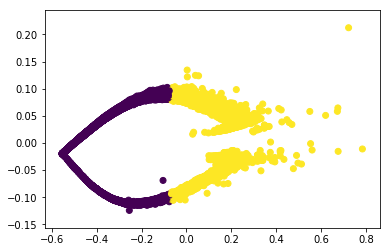

Comparing k-means clusters against the data:
col_0   pace
row_0       
0      10550
1      21434


In [8]:
# Normalize the data.
X_norm = normalize(marathon)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, time))

In [9]:
#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_norm,
    X_pca,
    test_size=0.9,
    random_state=42)

In [10]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 11


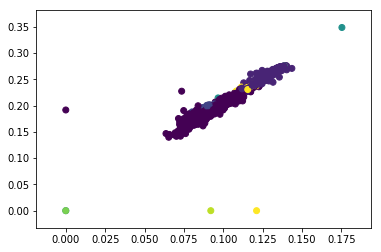

Comparing the assigned categories to the ones in the data:


Exception: Data must be 1-dimensional

In [11]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))